# Credit Scoring - Cash Plow

** Credit scoring is the way to measure the Credit worthiness of the Customer. **

Some of the parameters used in Credit Scoring are:
> * Payment mode (Cash/Online)
> * Credit period 
> * Frequency of purchase 
> * Total value of life time purchases from the supplier
> * Buyer Type 
> * Ticket size of transaction - total .value of 
> * period of relationship with buyer
> * Contractual relationship
> * Details of any official loan taken and status of the loan (This data will be available only with very few users)
> * Pending payments (receivable and payable balances) on a daily basis will be tracked
> * no.of years in business(2-10 years),
> * average transaction value - lifetime value/ no.of transaction
> * average Invoice value  - invoice_value / no.of items
> * frequency of purchases - 3, 6 and 9 Months

### Python Imports

In [2]:
## Imports ##

import pandas as pd

import numpy as np

from functools import reduce

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')
import scorecardpy as sc

from imblearn.over_sampling import SMOTE

import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt

### Class to Encode the columns using LabelEncoder

In [3]:
## Encode the given Categorical columns
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

### Function to create Labels (either good or bad) based on various conditions.

In [4]:
"""Create labels: 
Criteria: 
Good:
     No.of. Transactions>10 and 
     CreditPeriod <=15 or lifeTimeTotal > 200000
Otherwise, consider the transaction as bad."""
def applyLabel(df):
    if ( (df['total_transactions'] > 10) and  (df['No_of_years_in_business'] > 5) ) or (df['Life_time_total'] > 600000):
        return 1
    else:
        return 0

### Function to List Unique values in the column of Pandas DataFrame.

In [5]:
## List Unique values in specified columns or all columns in the DataFrame. ##

def listUniqueValues(df, col_list=[]):
    ## If col_list is empty get all the columns. ##
    if not col_list:
        col_list = df.columns.to_list()
    for col in col_list:
        print("Column Name:" , col)
        print(df[col].unique())
    

### Read the Sales Data and Contract Data

In [6]:
## Read the Sales Data and Contract Data. ##
sales_data = pd.read_csv('sales_data.csv')
contract_data = pd.read_csv('customer_contract_info.csv')

## Make a copy of Sales data. ##
original_sales_data = sales_data

## Make a copy of Sales data. ##
original_contract_data = contract_data

### Expore the Sales Data and Contract Data

In [7]:
## Check the Sales data
sales_data.head()

,Date,Month,Invouce no,Party Name,Customer type,Product,Quantity,UoM,Rate,Total,Mode of payment,Credit Period(In Days)
0,1-Apr-19,19-Apr,KDT/0001/19-20,Quality Foods,Processor,Cardamom,80.0,Kg,3500.0,280000,Online,60
1,1-Apr-19,19-Apr,KDT/0002/19-20,Saturam Traders,Commission Agent,Pepper,40.0,Kg,390.0,15600,Cash,0
2,2-Apr-19,19-Apr,KDT/0003/19-20,RS Enterprises,Wholesaler,Jaggery,40.0,Kg,70.0,2800,Cash,0
3,2-Apr-19,19-Apr,KDT/0003/19-20,RS Enterprises,Wholesaler,Cardamom,30.0,Kg,3650.0,109500,Online,60
4,2-Apr-19,19-Apr,KDT/0003/19-20,RS Enterprises,Wholesaler,Cardamom,10.0,Kg,3600.0,36000,Online,60


In [8]:
contract_data.describe()

,Party Name,Type,Contractual relationship
count,28,28,28
unique,28,8,2
top,RS Enterprises,Processor,No
freq,1,6,21


In [9]:
contract_data.head()

,Party Name,Type,Contractual relationship
0,ABC Traders,Commission Agent,No
1,Agri Vikas,Wholesaler,No
2,Amazon Exports,Exporters,No
3,Anand Agro,Processor,No
4,Apollo Traders,Wholesaler,No


In [10]:
## Replace the spaces in Column Names. ##
sales_data.columns =[column.replace(" ", "_") for column in sales_data.columns] 
contract_data.columns =[column.replace(" ", "_") for column in contract_data.columns] 

## Rename column 'Invouce_no'  to  'Invoice_No' in Sales Data. ##
sales_data = sales_data.rename(columns={"Invouce_no": "Invoice_No"})


## Drop the column 'Type' in Contract data. ##
contract_data = contract_data.drop(columns = ['Type'])

## Add New column 'No_of_years_in_Business' in Contract data. ##
contract_data['No_of_years_in_business'] = np.random.randint(2, 10, contract_data.shape[0])

In [11]:
sales_data.head()

,Date,Month,Invoice_No,Party_Name,Customer_type,Product,Quantity,UoM,Rate,Total,Mode_of_payment,Credit_Period(In_Days)
0,1-Apr-19,19-Apr,KDT/0001/19-20,Quality Foods,Processor,Cardamom,80.0,Kg,3500.0,280000,Online,60
1,1-Apr-19,19-Apr,KDT/0002/19-20,Saturam Traders,Commission Agent,Pepper,40.0,Kg,390.0,15600,Cash,0
2,2-Apr-19,19-Apr,KDT/0003/19-20,RS Enterprises,Wholesaler,Jaggery,40.0,Kg,70.0,2800,Cash,0
3,2-Apr-19,19-Apr,KDT/0003/19-20,RS Enterprises,Wholesaler,Cardamom,30.0,Kg,3650.0,109500,Online,60
4,2-Apr-19,19-Apr,KDT/0003/19-20,RS Enterprises,Wholesaler,Cardamom,10.0,Kg,3600.0,36000,Online,60


In [12]:
## List the Unique values for columns in Sales Data. ## 

col_list = ['Month', 'Party_Name', 'Customer_type', 'Product', 'Mode_of_payment', 'Credit_Period(In_Days)']
listUniqueValues(sales_data, col_list)

Column Name: Month
['19-Apr' '19-May' '19-Jun' '19-Jul' '19-Aug']
Column Name: Party_Name
['Quality Foods' 'Saturam Traders' 'RS Enterprises' 'PayAgri' 'ITC'
 'Sai Krishna Agencies' 'Vinayak Traders' 'Minazigy Agents'
 'Manohar Traders' 'Nutriplanet' 'Amazon Exports' 'Lucid Traders'
 'Anand Agro' 'Quality Agro' 'Kraft Food' 'Apollo Traders' 'Rajarams'
 'Jai Mahalzmi Traders' 'Organic Exports' 'Janatha Agro '
 'Malti Litch Traders' 'Krishna Industries' 'ABC Traders' 'Jayanth Agri'
 'Agri Vikas' 'RKR Agro' 'Kazhani FPC' 'Kailash Trading']
Column Name: Customer_type
['Processor' 'Commission Agent' 'Wholesaler' 'Retailer' 'Large Corporate'
 'Trader' 'Exporters' 'Corporate']
Column Name: Product
['Cardamom' 'Pepper' 'Jaggery' 'Maize' 'MAize' 'Fruits & Vegetables'
 'Wheat']
Column Name: Mode_of_payment
['Online' 'Cash' 'Bank']
Column Name: Credit_Period(In_Days)
[60  0 30 15]


In [13]:
listUniqueValues(contract_data)

Column Name: Party_Name
['ABC Traders' 'Agri Vikas' 'Amazon Exports' 'Anand Agro' 'Apollo Traders'
 'ITC' 'Jai Mahalzmi Traders' 'Janatha Agro ' 'Jayanth Agri'
 'Kailash Trading' 'Kazhani FPC' 'Kraft Food' 'Krishna Industries'
 'Lucid Traders' 'Malti Litch Traders' 'Manohar Traders' 'Minazigy Agents'
 'Nutriplanet' 'Organic Exports' 'PayAgri' 'Quality Agro' 'Quality Foods'
 'Rajarams' 'RKR Agro' 'RS Enterprises' 'Sai Krishna Agencies'
 'Saturam Traders' 'Vinayak Traders']
Column Name: Contractual_relationship
['No' 'Yes']
Column Name: No_of_years_in_business
[8 6 5 7 2 4 3 9]


In [14]:
## Drop the 'Product', 'Quantity', 'UoM', 'Rate', 'Date' columns ## 
df1 = sales_data.drop(columns = ['Product', 'Quantity', 'UoM', 'Rate', 'Date'])
sales_data_grouped1 = df1.groupby(['Invoice_No', 'Party_Name', 'Customer_type', 'Credit_Period(In_Days)', 'Mode_of_payment'], as_index=False)['Total'].sum()


## Find the lifetime value of the customer 
life_time_total_df = sales_data.drop(columns = ['Invoice_No', 'Credit_Period(In_Days)', 'Mode_of_payment', 'Product', 'Quantity', 'UoM', 'Rate', 'Date', 'Month'])
life_time_total_df = life_time_total_df.rename(columns={"Total": "Life_time_total"})

life_time_total = life_time_total_df.groupby(['Party_Name', 'Customer_type'], as_index=False)['Life_time_total'].sum()


In [15]:
life_time_total

,Party_Name,Customer_type,Life_time_total
0,ABC Traders,Commission Agent,963597
1,Agri Vikas,Wholesaler,366013
2,Amazon Exports,Exporters,1136300
3,Anand Agro,Processor,295400
4,Apollo Traders,Wholesaler,311806
5,ITC,Large Corporate,1727420
6,Jai Mahalzmi Traders,Trader,199360
7,Janatha Agro,Retailer,567640
8,Jayanth Agri,Trader,314316
9,Kailash Trading,Processor,162700


In [16]:
df1_monthly_data = df1.groupby(['Party_Name', 'Month']).size().reset_index(name='count')

monthly_pivot = df1_monthly_data.pivot_table('count', ['Party_Name'], 'Month')
monthly_pivot.reset_index( drop=False, inplace=True )
monthly_pivot = monthly_pivot.reindex(['Party_Name', '19-Apr', '19-May', '19-Jun', '19-Jul', '19-Aug'], axis=1)
monthly_col_list = ['19-Apr', '19-May', '19-Jun', '19-Jul', '19-Aug']
monthly_pivot[monthly_col_list] = monthly_pivot[monthly_col_list].fillna(0.0).astype(int)
monthly_pivot['total_transactions'] = monthly_pivot.sum(axis=1)

monthly_pivot

Month,Party_Name,19-Apr,19-May,19-Jun,19-Jul,19-Aug,total_transactions
0,ABC Traders,8,14,19,14,18,73
1,Agri Vikas,2,3,2,6,3,16
2,Amazon Exports,15,22,14,21,7,79
3,Anand Agro,4,4,6,3,3,20
4,Apollo Traders,8,0,0,13,7,28
5,ITC,5,7,4,4,5,25
6,Jai Mahalzmi Traders,4,2,4,5,1,16
7,Janatha Agro,7,8,6,5,4,30
8,Jayanth Agri,2,8,0,1,6,17
9,Kailash Trading,0,5,5,1,5,16


In [17]:
df1_mode_of_payment_data = df1.groupby(['Party_Name', 'Mode_of_payment']).size().reset_index(name='count')
df1_mode_of_payment_data
mode_of_payment_pivot = df1_mode_of_payment_data.pivot_table('count', ['Party_Name'], 'Mode_of_payment')
mode_of_payment_pivot.reset_index( drop=False, inplace=True )


mode_of_payment_pivot = mode_of_payment_pivot.rename(columns={"Bank": "Bank_count", "Cash": "Cash_count","Online":"Online_count" })

mode_of_payment_col_list = ['Bank_count', 'Cash_count', 'Online_count']
mode_of_payment_pivot[mode_of_payment_col_list] = mode_of_payment_pivot[mode_of_payment_col_list].fillna(0.0).astype(int)

mode_of_payment_pivot

Mode_of_payment,Party_Name,Bank_count,Cash_count,Online_count
0,ABC Traders,67,6,0
1,Agri Vikas,0,7,9
2,Amazon Exports,0,0,79
3,Anand Agro,3,16,1
4,Apollo Traders,0,26,2
5,ITC,0,0,25
6,Jai Mahalzmi Traders,0,14,2
7,Janatha Agro,0,17,13
8,Jayanth Agri,0,10,7
9,Kailash Trading,0,15,1


In [18]:
df1_credit_period_data = df1.groupby(['Party_Name', 'Credit_Period(In_Days)']).size().reset_index(name='count')
df1_credit_period_data

credit_period_pivot = df1_credit_period_data.pivot_table('count', ['Party_Name'], 'Credit_Period(In_Days)')
credit_period_pivot.reset_index( drop=False, inplace=True )


credit_period_pivot = credit_period_pivot.rename(columns={0: "Credit_Period_0_count", 
                                                          15: "Credit_Period_15_count",
                                                          30:"Credit_Period_30_count",
                                                         60 : "Credit_Period_60_count"})


credit_period_col_list = ['Credit_Period_0_count', 'Credit_Period_15_count', 'Credit_Period_30_count', 'Credit_Period_60_count']
credit_period_pivot[credit_period_col_list] = credit_period_pivot[credit_period_col_list].fillna(0.0).astype(int)
credit_period_pivot


Credit_Period(In_Days),Party_Name,Credit_Period_0_count,Credit_Period_15_count,Credit_Period_30_count,Credit_Period_60_count
0,ABC Traders,8,0,65,0
1,Agri Vikas,7,0,0,9
2,Amazon Exports,0,79,0,0
3,Anand Agro,16,0,0,4
4,Apollo Traders,26,0,0,2
5,ITC,0,0,0,25
6,Jai Mahalzmi Traders,14,0,2,0
7,Janatha Agro,17,0,0,13
8,Jayanth Agri,10,0,7,0
9,Kailash Trading,15,0,0,1


In [19]:
## Merge the Mode_of_payment, Credit Period, Monthly sales dataframes. 

data_frames = [monthly_pivot, mode_of_payment_pivot, credit_period_pivot, life_time_total, contract_data]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Party_Name'],
                                            how='outer'), data_frames)


df_merged

,Party_Name,19-Apr,19-May,19-Jun,19-Jul,19-Aug,total_transactions,Bank_count,Cash_count,Online_count,Credit_Period_0_count,Credit_Period_15_count,Credit_Period_30_count,Credit_Period_60_count,Customer_type,Life_time_total,Contractual_relationship,No_of_years_in_business
0,ABC Traders,8,14,19,14,18,73,67,6,0,8,0,65,0,Commission Agent,963597,No,8
1,Agri Vikas,2,3,2,6,3,16,0,7,9,7,0,0,9,Wholesaler,366013,No,6
2,Amazon Exports,15,22,14,21,7,79,0,0,79,0,79,0,0,Exporters,1136300,No,5
3,Anand Agro,4,4,6,3,3,20,3,16,1,16,0,0,4,Processor,295400,No,7
4,Apollo Traders,8,0,0,13,7,28,0,26,2,26,0,0,2,Wholesaler,311806,No,5
5,ITC,5,7,4,4,5,25,0,0,25,0,0,0,25,Large Corporate,1727420,Yes,2
6,Jai Mahalzmi Traders,4,2,4,5,1,16,0,14,2,14,0,2,0,Trader,199360,No,2
7,Janatha Agro,7,8,6,5,4,30,0,17,13,17,0,0,13,Retailer,567640,No,4
8,Jayanth Agri,2,8,0,1,6,17,0,10,7,10,0,7,0,Trader,314316,No,3
9,Kailash Trading,0,5,5,1,5,16,0,15,1,15,0,0,1,Processor,162700,No,2


### Data Preprocessing

In [20]:
## Apply Label Encoder
final_df = MultiColumnLabelEncoder(columns = ['Customer_type', 'Contractual_relationship']).fit_transform(df_merged)


In [21]:
final_df

,Party_Name,19-Apr,19-May,19-Jun,19-Jul,19-Aug,total_transactions,Bank_count,Cash_count,Online_count,Credit_Period_0_count,Credit_Period_15_count,Credit_Period_30_count,Credit_Period_60_count,Customer_type,Life_time_total,Contractual_relationship,No_of_years_in_business
0,ABC Traders,8,14,19,14,18,73,67,6,0,8,0,65,0,0,963597,0,8
1,Agri Vikas,2,3,2,6,3,16,0,7,9,7,0,0,9,7,366013,0,6
2,Amazon Exports,15,22,14,21,7,79,0,0,79,0,79,0,0,2,1136300,0,5
3,Anand Agro,4,4,6,3,3,20,3,16,1,16,0,0,4,4,295400,0,7
4,Apollo Traders,8,0,0,13,7,28,0,26,2,26,0,0,2,7,311806,0,5
5,ITC,5,7,4,4,5,25,0,0,25,0,0,0,25,3,1727420,1,2
6,Jai Mahalzmi Traders,4,2,4,5,1,16,0,14,2,14,0,2,0,6,199360,0,2
7,Janatha Agro,7,8,6,5,4,30,0,17,13,17,0,0,13,5,567640,0,4
8,Jayanth Agri,2,8,0,1,6,17,0,10,7,10,0,7,0,6,314316,0,3
9,Kailash Trading,0,5,5,1,5,16,0,15,1,15,0,0,1,4,162700,0,2


In [22]:
final_df['label'] = final_df.apply(applyLabel, axis=1)


In [23]:
final_df['label'].value_counts()


1    19
0     9
Name: label, dtype: int64

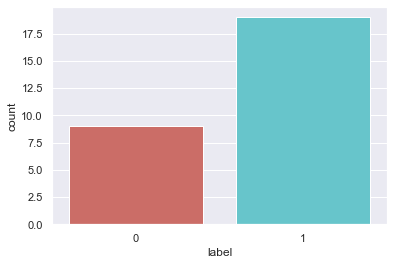

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=final_df, palette='hls')


### Split the dataset into Training and testinng

In [25]:
model_df = final_df.drop('Party_Name', axis = 1)
model_df

,19-Apr,19-May,19-Jun,19-Jul,19-Aug,total_transactions,Bank_count,Cash_count,Online_count,Credit_Period_0_count,Credit_Period_15_count,Credit_Period_30_count,Credit_Period_60_count,Customer_type,Life_time_total,Contractual_relationship,No_of_years_in_business,label
0,8,14,19,14,18,73,67,6,0,8,0,65,0,0,963597,0,8,1
1,2,3,2,6,3,16,0,7,9,7,0,0,9,7,366013,0,6,1
2,15,22,14,21,7,79,0,0,79,0,79,0,0,2,1136300,0,5,1
3,4,4,6,3,3,20,3,16,1,16,0,0,4,4,295400,0,7,1
4,8,0,0,13,7,28,0,26,2,26,0,0,2,7,311806,0,5,0
5,5,7,4,4,5,25,0,0,25,0,0,0,25,3,1727420,1,2,1
6,4,2,4,5,1,16,0,14,2,14,0,2,0,6,199360,0,2,0
7,7,8,6,5,4,30,0,17,13,17,0,0,13,5,567640,0,4,0
8,2,8,0,1,6,17,0,10,7,10,0,7,0,6,314316,0,3,0
9,0,5,5,1,5,16,0,15,1,15,0,0,1,4,162700,0,2,0


In [26]:
X=model_df
y=model_df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [27]:
X_train

,19-Apr,19-May,19-Jun,19-Jul,19-Aug,total_transactions,Bank_count,Cash_count,Online_count,Credit_Period_0_count,Credit_Period_15_count,Credit_Period_30_count,Credit_Period_60_count,Customer_type,Life_time_total,Contractual_relationship,No_of_years_in_business,label
25,11,9,7,9,8,44,0,36,8,36,0,8,0,6,659990,0,5,1
16,2,10,2,0,7,21,19,2,0,2,0,19,0,0,357479,0,8,1
1,2,3,2,6,3,16,0,7,9,7,0,0,9,7,366013,0,6,1
10,0,16,16,1,14,47,0,42,5,45,0,2,0,6,549728,0,9,1
27,15,8,12,11,10,56,45,11,0,13,0,43,0,0,514480,0,8,1
26,20,22,36,21,24,123,104,19,0,21,0,102,0,0,1229020,0,5,1
8,2,8,0,1,6,17,0,10,7,10,0,7,0,6,314316,0,3,0
6,4,2,4,5,1,16,0,14,2,14,0,2,0,6,199360,0,2,0
4,8,0,0,13,7,28,0,26,2,26,0,0,2,7,311806,0,5,0
18,4,11,6,7,6,34,0,0,34,34,0,0,0,2,559895,1,2,0


### Logistic Regression

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67


In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[0 3]
 [0 6]]


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      1.00      0.80         6

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



### Create WoE and IV

[INFO] creating woe binning ...


{'Bank_count': <Figure size 432x288 with 2 Axes>,
 'Cash_count': <Figure size 432x288 with 2 Axes>,
 'Online_count': <Figure size 432x288 with 2 Axes>,
 'Credit_Period_0_count': <Figure size 432x288 with 2 Axes>,
 'Credit_Period_15_count': <Figure size 432x288 with 2 Axes>,
 'Credit_Period_30_count': <Figure size 432x288 with 2 Axes>,
 'Credit_Period_60_count': <Figure size 432x288 with 2 Axes>,
 'Customer_type': <Figure size 432x288 with 2 Axes>,
 'Contractual_relationship': <Figure size 432x288 with 2 Axes>,
 'No_of_years_in_business': <Figure size 432x288 with 2 Axes>,
 '19-Apr': <Figure size 432x288 with 2 Axes>,
 '19-May': <Figure size 432x288 with 2 Axes>,
 '19-Jun': <Figure size 432x288 with 2 Axes>,
 '19-Jul': <Figure size 432x288 with 2 Axes>,
 '19-Aug': <Figure size 432x288 with 2 Axes>}

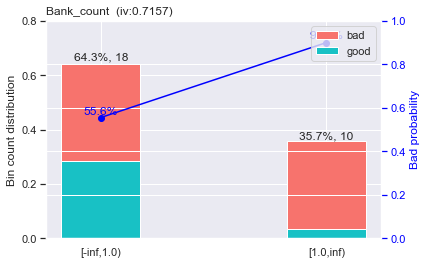

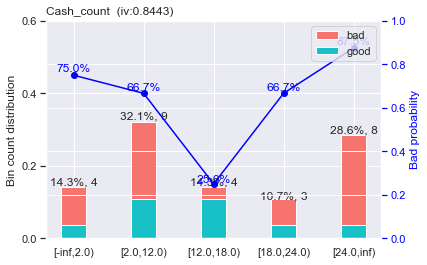

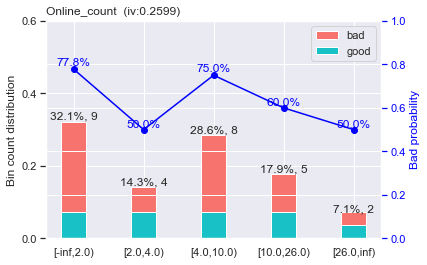

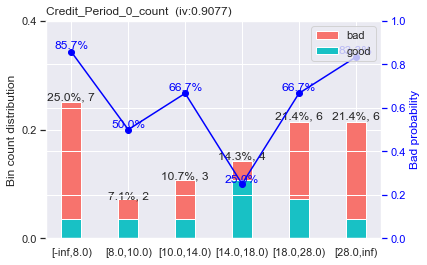

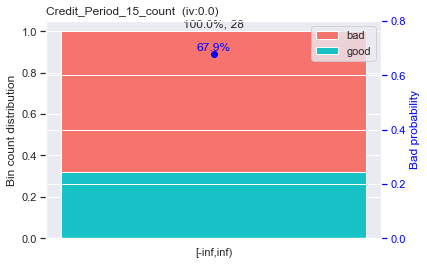

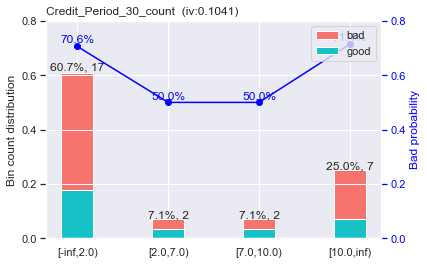

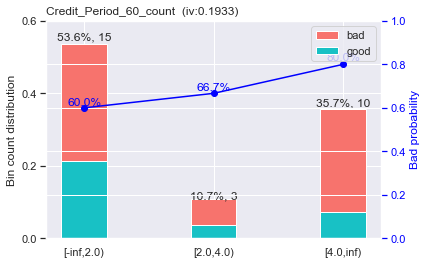

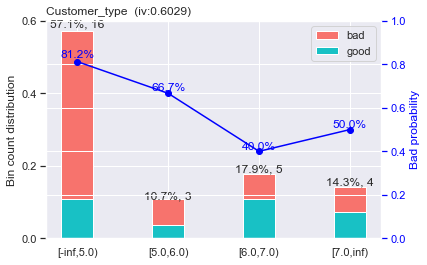

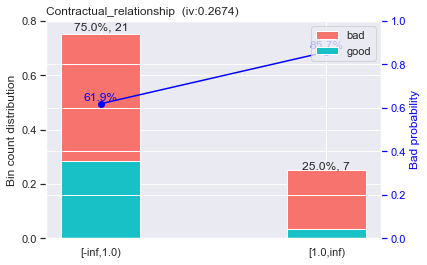

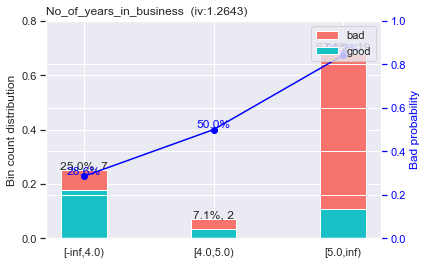

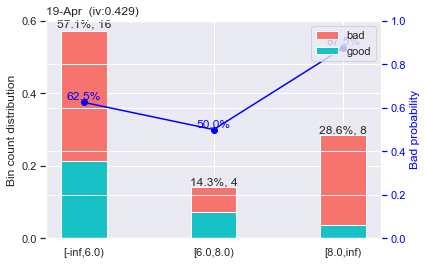

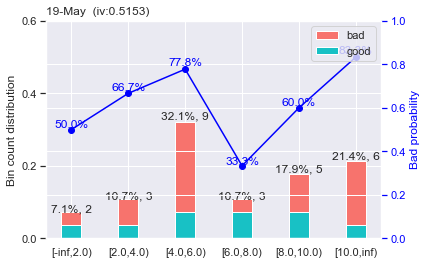

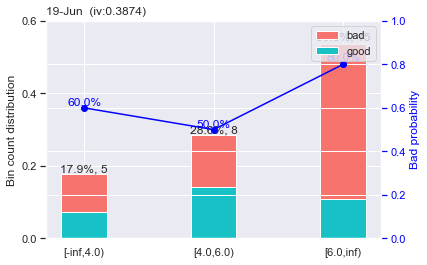

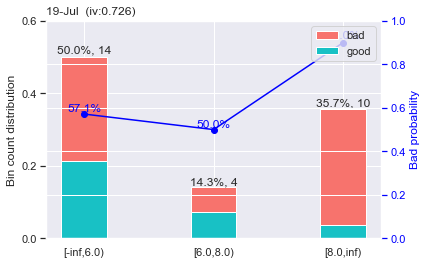

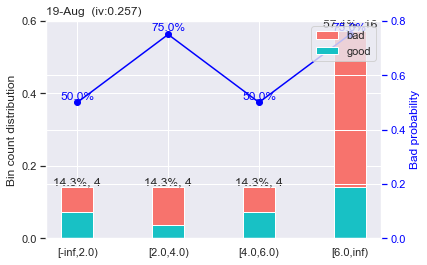

In [31]:

df_train, df_test = train_test_split(model_df,  random_state=0)

data_final_vars = model_df.columns.values.tolist()
y=['label']
X=[i for i in data_final_vars if i not in y]


# woe binning ------
bins = sc.woebin(final_df, y="label", x = ['Bank_count', 'Cash_count', 'Online_count', 
                                           'Credit_Period_0_count', 'Credit_Period_15_count', 
                                           'Credit_Period_30_count', 'Credit_Period_60_count', 
                                           'Customer_type','Contractual_relationship', 'No_of_years_in_business',
                                           '19-Apr', '19-May', '19-Jun', '19-Jul', '19-Aug'
                                          ])
sc.woebin_plot(bins)

In [32]:
# binning adjustment
# # adjust breaks interactively
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
breaks_adj = {
    'Credit_Period(In_Days)': [0, 15, 30, 60]
    
}
bins_adj = sc.woebin(final_df, y="label" )

# converting train and test into woe values
train_woe = sc.woebin_ply(df_train, bins_adj)
test_woe = sc.woebin_ply(df_test, bins_adj)

[INFO] creating woe binning ...
Binning on 28 rows and 19 columns in 00:00:10
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [33]:
ytrain = train_woe.loc[:,'label']
xtrain = train_woe.loc[:, train_woe.columns != 'label']
ytest = test_woe.loc[:,'label']
xtest = test_woe.loc[:, test_woe.columns != 'label']

print("shape of xtrain: {}".format(xtrain.shape))
print("shape of xtest: {}".format(xtest.shape))


shape of xtrain: (21, 17)
shape of xtest: (7, 17)


In [34]:
xtest

,Credit_Period_15_count_woe,Credit_Period_60_count_woe,Contractual_relationship_woe,Credit_Period_30_count_woe,19-Aug_woe,Online_count_woe,19-Apr_woe,Cash_count_woe,Credit_Period_0_count_woe,19-Jun_woe,19-Jul_woe,Customer_type_woe,Bank_count_woe,19-May_woe,total_transactions_woe,Life_time_total_woe,No_of_years_in_business_woe
2,0.0,-0.341749,-0.261707,0.128254,0.351398,-0.747214,1.198696,0.351398,1.044545,0.639080,1.450010,0.719123,-0.524071,0.862224,0.957534,0.719123,0.926762
5,0.0,0.639080,1.044545,0.128254,-0.747214,-0.341749,-0.236389,0.351398,1.044545,-0.747214,-0.459532,0.719123,-0.524071,-1.440362,-1.440362,0.719123,-1.663505
11,0.0,0.639080,-0.261707,0.128254,0.351398,0.351398,1.198696,1.198696,-0.054067,0.639080,-0.459532,-0.054067,-0.524071,0.505549,0.957534,-1.034896,0.926762
14,0.0,-0.341749,-0.261707,0.169076,-0.747214,0.505549,-0.236389,-0.054067,1.044545,-0.747214,-0.747214,0.719123,1.450010,0.505549,0.639080,-1.034896,-1.663505
17,0.0,-0.054067,1.044545,0.128254,0.351398,-0.747214,-0.236389,1.198696,-0.054067,-0.341749,1.450010,0.719123,-0.524071,0.505549,0.957534,-0.341749,0.926762
22,0.0,0.639080,1.044545,0.128254,-0.747214,-0.341749,-0.236389,0.351398,1.044545,0.639080,-0.747214,0.719123,-0.524071,-0.054067,-1.034896,0.719123,0.926762
24,0.0,-0.341749,1.044545,0.128254,-0.747214,0.505549,-0.236389,-0.054067,-0.054067,0.639080,-0.459532,0.719123,1.450010,0.505549,0.639080,-0.341749,0.926762


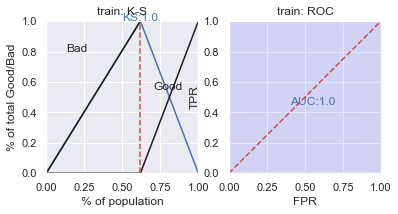

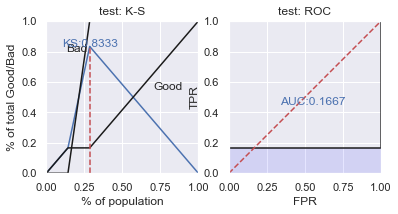

AttributeError: 'DataFrame' object has no attribute 'distr'

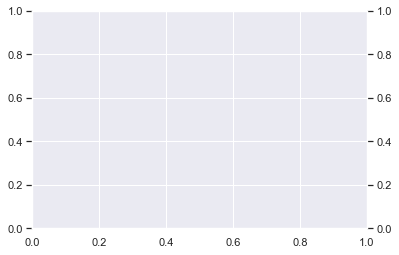

In [35]:
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(xtrain, ytrain)
# lr.coef_
# lr.intercept_

# predicted proability
train_pred = lr.predict_proba(xtrain)[:,1]
test_pred = lr.predict_proba(xtest)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(ytrain, train_pred, title = "train")
test_perf = sc.perf_eva(ytest, test_pred, title = "test")

# score ------
card = sc.scorecard(bins_adj, lr, xtrain.columns)
# credit score
train_score = sc.scorecard_ply(df_train, card, print_step=0)
test_score = sc.scorecard_ply(df_test, card, print_step=0)

# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':ytrain, 'test':ytest}
)

In [ ]:
train_score

In [36]:
test_score

,score
2,271.0
5,464.0
11,337.0
14,173.0
17,337.0
22,359.0
24,152.0


In [37]:
result_df = pd.concat([train_score, test_score])

In [38]:
result_df

,score
0,180.0
1,359.0
3,260.0
4,443.0
6,620.0
7,501.0
8,512.0
9,620.0
10,282.0
12,313.0


In [39]:
result_df.sort_index(inplace=True)


In [40]:
result_df

,score
0,180.0
1,359.0
2,271.0
3,260.0
4,443.0
5,464.0
6,620.0
7,501.0
8,512.0
9,620.0


In [41]:
life_time_total['Credit_Score'] = result_df.score
final_result_df = life_time_total
final_result_df

,Party_Name,Customer_type,Life_time_total,Credit_Score
0,ABC Traders,Commission Agent,963597,180.0
1,Agri Vikas,Wholesaler,366013,359.0
2,Amazon Exports,Exporters,1136300,271.0
3,Anand Agro,Processor,295400,260.0
4,Apollo Traders,Wholesaler,311806,443.0
5,ITC,Large Corporate,1727420,464.0
6,Jai Mahalzmi Traders,Trader,199360,620.0
7,Janatha Agro,Retailer,567640,501.0
8,Jayanth Agri,Trader,314316,512.0
9,Kailash Trading,Processor,162700,620.0
